<a href="https://colab.research.google.com/github/Hodik/learning/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-01-26 12:18:15--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2024-01-26 12:18:15 (21.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
Cdims = 10

In [73]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, Cdims), generator=g)
W1 = torch.randn((Cdims * block_size, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [74]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [75]:
for p in parameters:
  p.requires_grad = True

In [76]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [77]:
lri = []
lossi = []
stepi = []
mini_batch = 128

In [78]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (mini_batch,))

  # forward pass
  emb = C[Xtr[ix]] # (mini_batch, block_size, Cdims)
  h = torch.tanh(emb.view(-1, Cdims * block_size) @ W1 + b1) # (mini_batch, Cdims * block_size)
  logits = h @ W2 + b2 # (mini_batch, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.0777769088745117


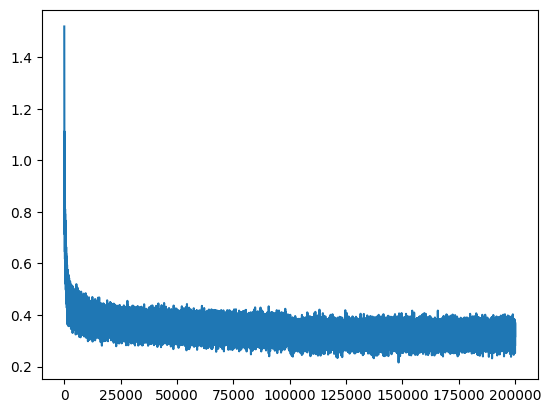

In [79]:
plt.plot(stepi, lossi)

In [80]:
# training loss
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1076, grad_fn=<NllLossBackward0>)

In [82]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1585, grad_fn=<NllLossBackward0>)

In [83]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1642, grad_fn=<NllLossBackward0>)

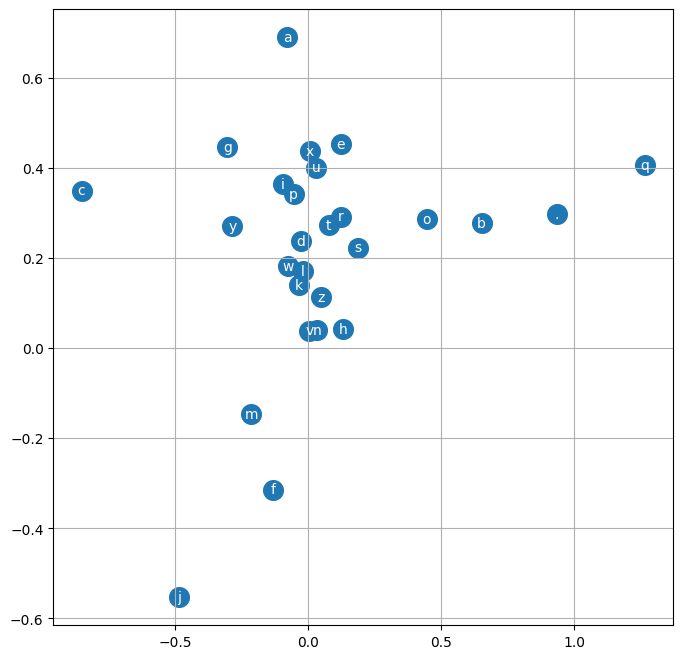

In [86]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [85]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    new_name = ''.join(itos[i] for i in out)
    print(f"{new_name=} {new_name in words}")

new_name='reenaiyn.' False
new_name='kaz.' False
new_name='shara.' False
new_name='nearyan.' False
new_name='nikariezlyn.' False
new_name='sric.' False
new_name='ceel.' False
new_name='jaxz.' False
new_name='evvi.' False
new_name='amela.' False
new_name='ker.' False
new_name='anis.' False
new_name='malayeekseli.' False
new_name='zaue.' False
new_name='jedlies.' False
new_name='lor.' False
new_name='kalex.' False
new_name='sten.' False
new_name='marshestoni.' False
new_name='kalylah.' False
